In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(rtracklayer)
    library(tidyverse)
    library(ggbeeswarm)
    library(purrr)
    library(parallel)
    library(slimr)
    library(stringr)
    library(forcats)
    library(bodkanr)
    library(here)
})

In [2]:
assembly_gaps_path <- here("data/RData/assembly_gaps.rds")

if (!file.exists(assembly_gaps_path)) {
    assembly_gaps <- get_gaps()
    saveRDS(assembly_gaps, assembly_gaps_path)
} else {
    assembly_gaps <- readRDS(assembly_gaps_path)
}

In [67]:
find_deserts <- function(vcf_path, region, chrom) {
    vcf <- read_vcf(vcf_path)

    real_markers <- read_coordinates(here("data/slim_coords/" %+% region %+% "_unif_all_sites.bed"))
    real_markers <- real_markers[real_markers$real_chrom == chrom, ]
    start(real_markers) <- start(real_markers) - start(real_markers)[1]
    end(real_markers) <- end(real_markers) - end(real_markers)[1]

    slim_markers <- mut_info(vcf, mut_type = 1)

    slim_markers <- fill_lost(slim_markers, real_markers) %>% transpose_coordinates(real_markers)
    
    deserts <- ancestry_deserts(slim_markers)

    if (is.null(deserts)) return(NULL)
    desert_hits <- queryHits(findOverlaps(deserts, assembly_gaps))
    nogap_deserts <- if (length(desert_hits)) deserts[-desert_hits] else deserts
        
    nogap_deserts
}

### Single pulse of admixture

In [4]:
desert_sizes <- map_dfr(c("selection", "neutral"), function(scenario) {

map_dfr(1:100, function(rep_i) {

map_dfr(c("chr1", "chr7"), function(chrom) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p2_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    if (is.null(deserts)) return(NULL)

    return(tibble(chrom = chrom, scenario = scenario, size=width(deserts), rep=rep_i))

})

})

})

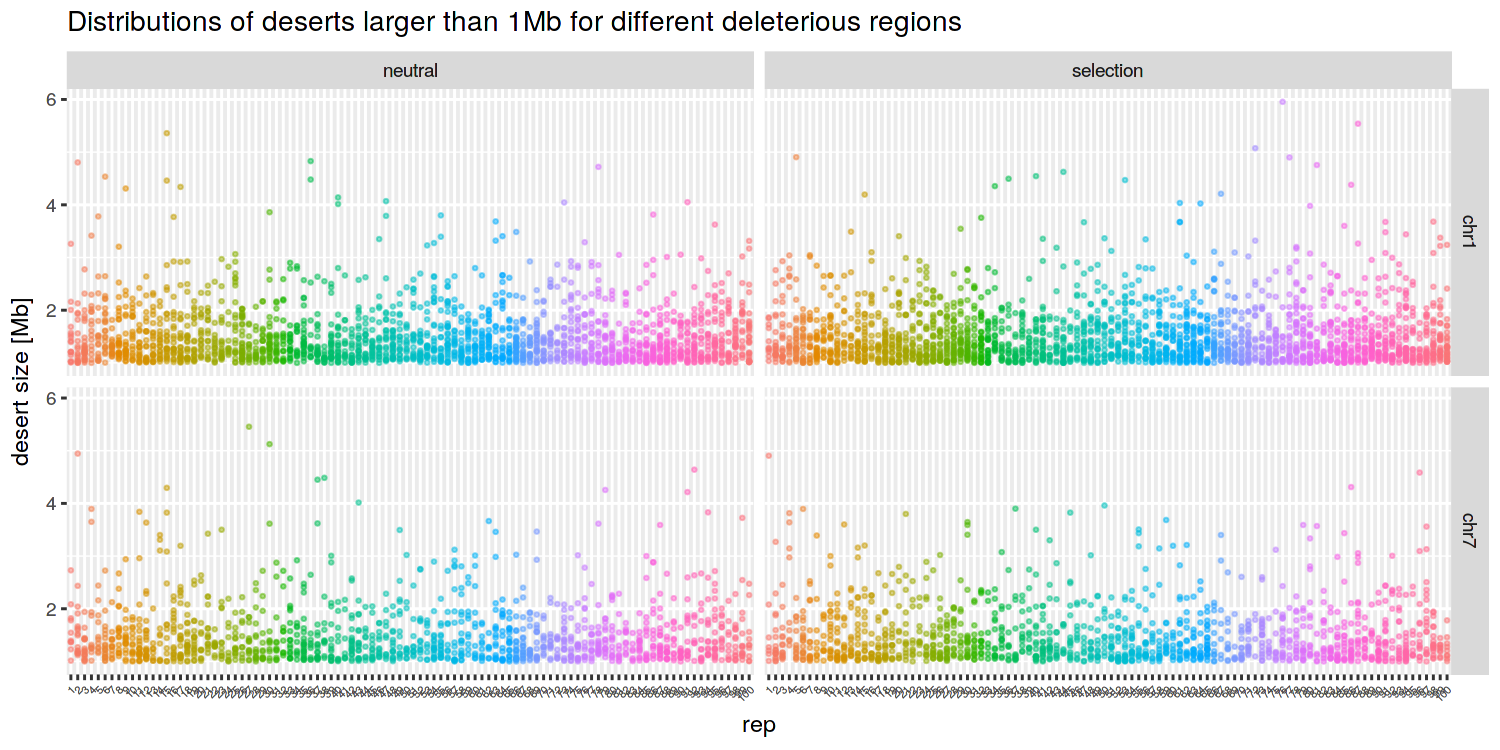

In [60]:
set_dim(10, 5)

group_by(desert_sizes, scenario, rep) %>% filter(size > 1e6) %>% ungroup %>% mutate(rep = factor(rep)) %>%
ggplot(aes(rep, size / 1e6, color=rep)) + geom_point(alpha=1/2, size=0.5) +
ggtitle("Distributions of deserts larger than 1Mb for different deleterious regions") +
ylab("desert size [Mb]") +
facet_grid(chrom ~ scenario) +
theme(legend.position="botom", axis.text.x=element_text(size=5, hjust=1, angle=45))

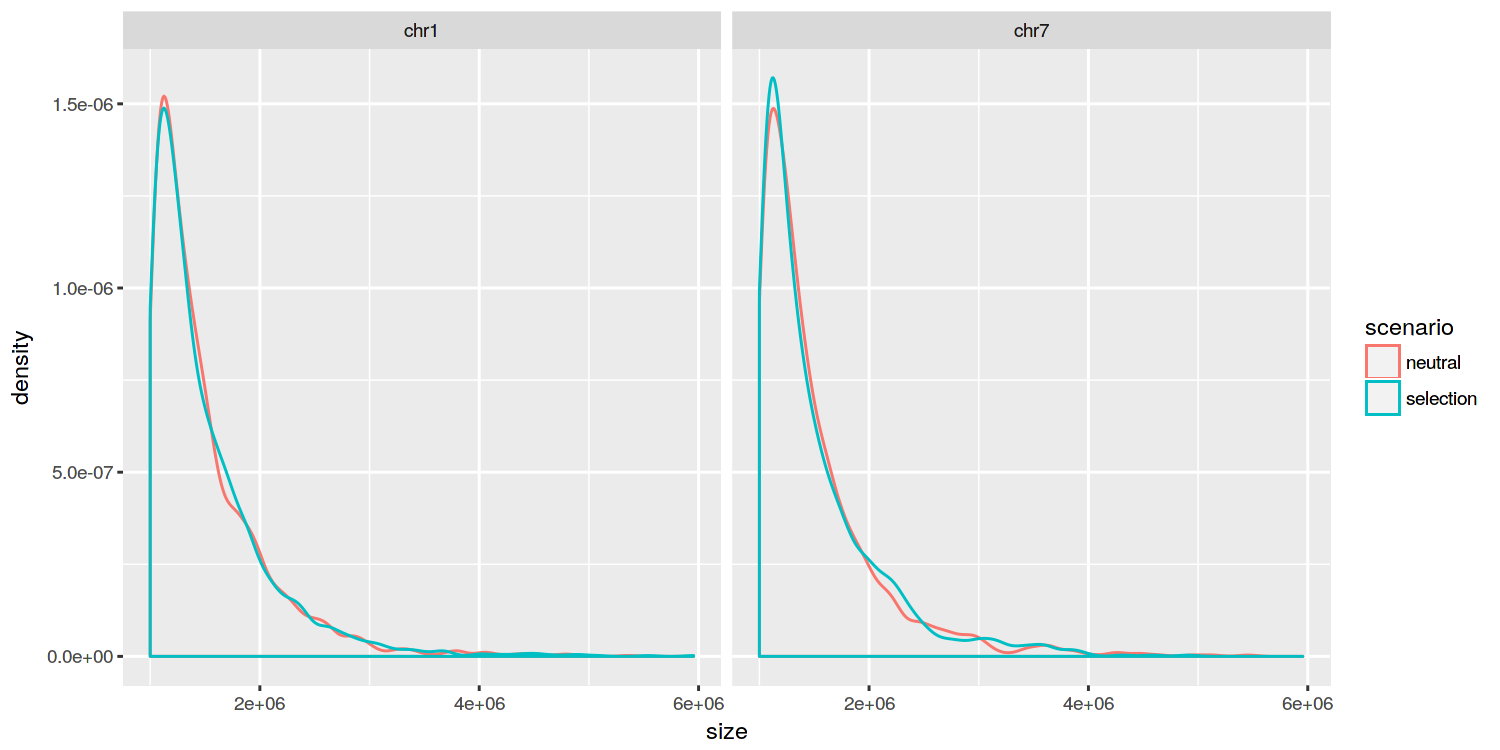

In [62]:
desert_sizes %>% filter(size > 1e6) %>%
ggplot(aes(size, color = scenario)) + geom_density() + facet_grid(~ chrom)

# Neandertal deserts from 20 independent burnins

In [6]:
trajectories <- suppressMessages(bind_rows(
    map_dfr(list.files(here("data/deserts"), "selection_chr1_source_p2_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(rep = .x, chrom = "chr1", scenario = "selection")),
    map_dfr(list.files(here("data/deserts"), "selection_chr7_source_p2_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(rep = .x, chrom = "chr7", scenario = "selection")),
    map_dfr(list.files(here("data/deserts"), "neutral_chr1_source_p2_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(rep = .x, chrom = "chr1", scenario = "neutral")),
    map_dfr(list.files(here("data/deserts"), "neutral_chr7_source_p2_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(rep = .x, chrom = "chr7", scenario = "neutral"))
))

`geom_smooth()` using method = 'gam'


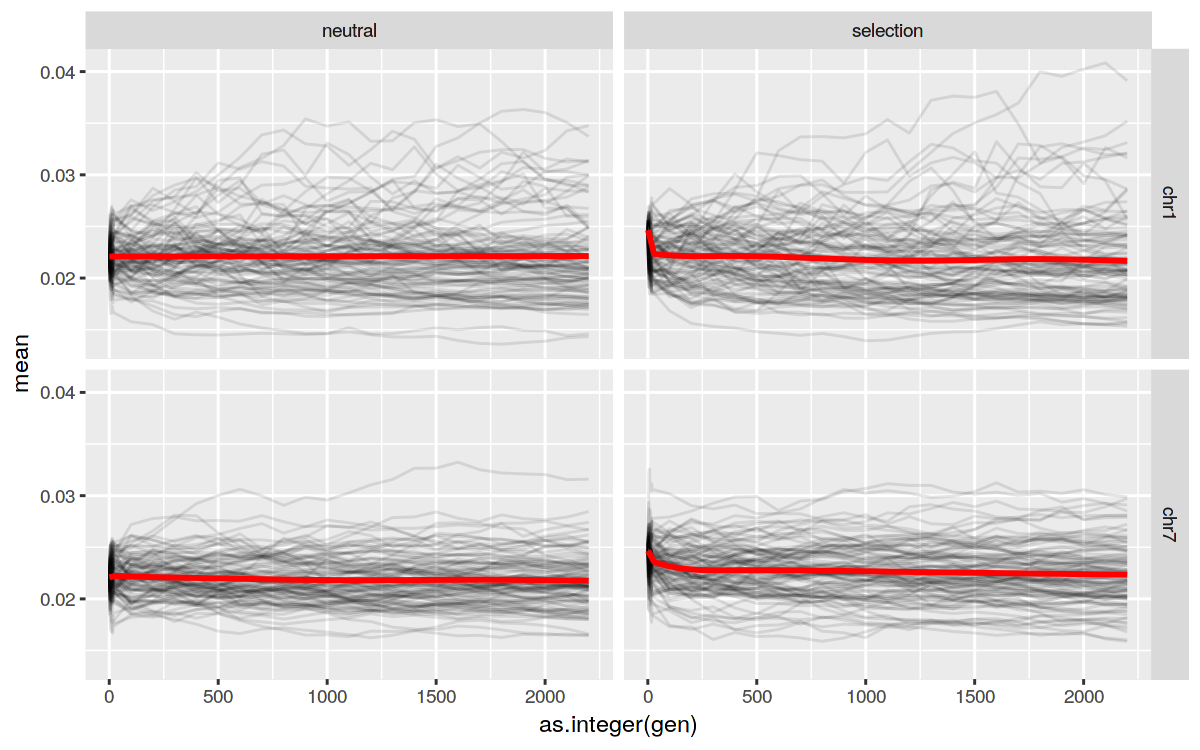

In [7]:
set_dim(8, 5)

ggplot(trajectories, aes(as.integer(gen), mean, group = rep)) +
    geom_line(alpha = 1/10) + geom_smooth(aes(group = 1), color = "red") +
    facet_grid(chrom ~ scenario)

In [8]:
filter(trajectories, gen == 2200) %>% group_by(chrom, scenario, gen) %>% summarise(mean(mean))

chrom,scenario,gen,mean(mean)
chr1,neutral,2200,0.02199304
chr1,selection,2200,0.02172615
chr7,neutral,2200,0.02175950
chr7,selection,2200,0.02235322


## Overlap of deserts

Let's take the 10 biggest deserts from each exon replicate and look at their overlap.

In [10]:
library(ggbio)

Need specific help about ggbio? try mailing 
 the maintainer or visit http://tengfei.github.com/ggbio/

Attaching package: 'ggbio'

The following objects are masked from 'package:ggplot2':

    geom_bar, geom_rect, geom_segment, ggsave, stat_bin, stat_identity,
    xlim



In [64]:
scenario <- "selection"
size_cutoff <- 3e6

In [68]:
chrom <- "chr7"

chr7_nea <- map(1:100, function(rep_i) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p2_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    largest <- deserts[width(deserts) > size_cutoff]
    
    if (! length(largest)) return(GRanges())

    largest$rep <- rep_i
    largest$pop <- "Neandertal"
    
    largest

}) %>% GRangesList

chr7_den <- map(1:100, function(rep_i) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p4_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    largest <- deserts[width(deserts) > size_cutoff]
    
    if (! length(largest)) return(GRanges())

    largest$rep <- rep_i
    largest$pop <- "Denisovan"
    
    largest

}) %>% GRangesList

Warning message in if (as.character(args$fill) == "strand") isStrand.fill <- TRUE:
"the condition has length > 1 and only the first element will be used"

Warning message in if (as.character(args$fill) == "strand") isStrand.fill <- TRUE:
"the condition has length > 1 and only the first element will be used"

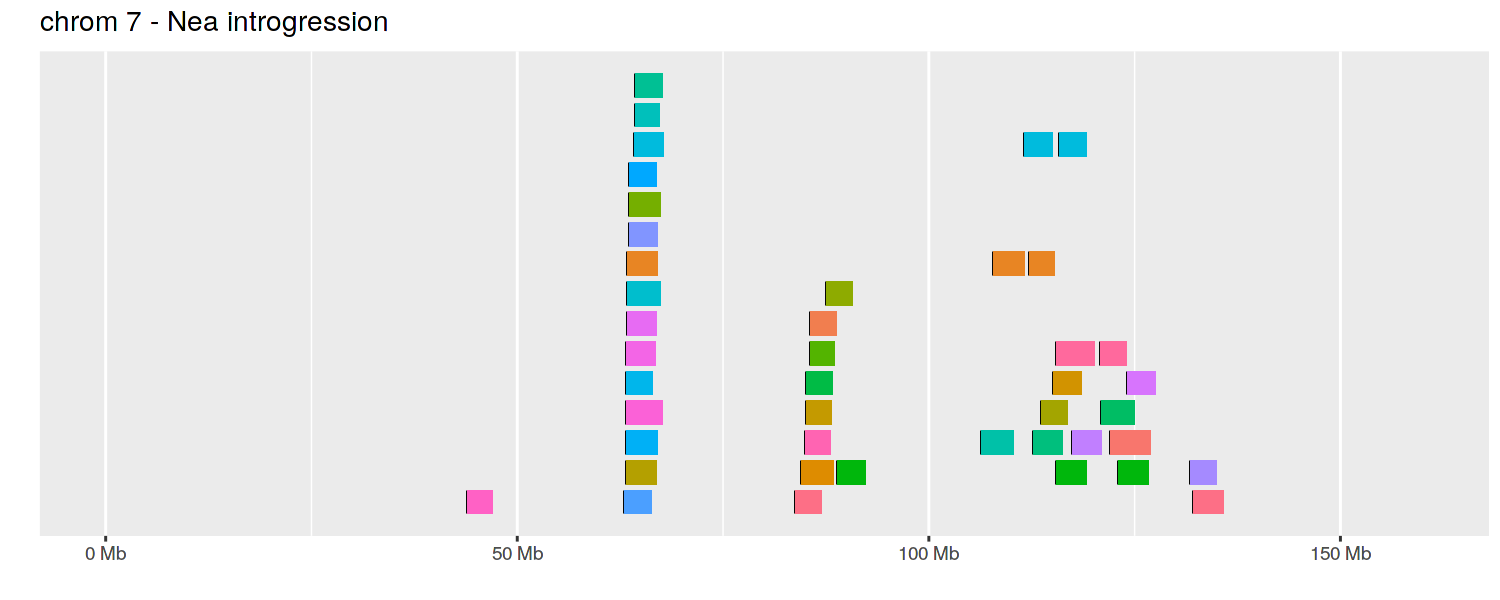

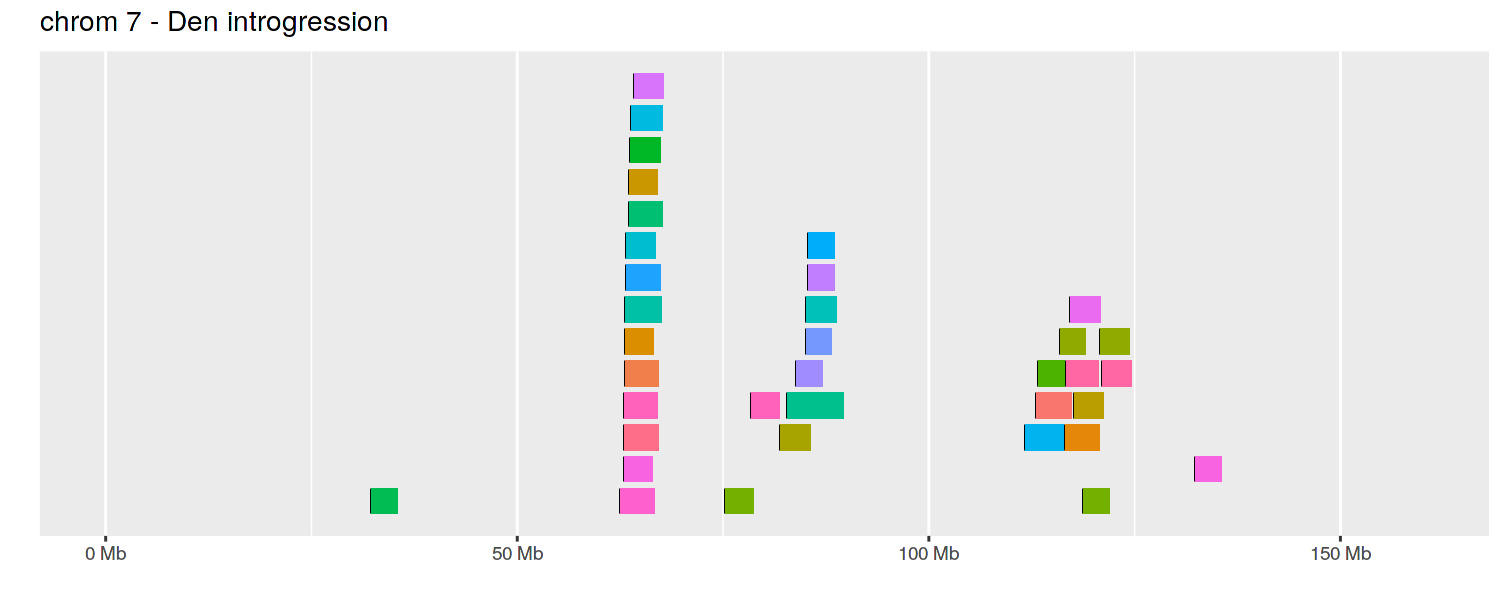

In [69]:
set_dim(10, 4)

autoplot(chr7_nea, stat = "reduce", aes(fill = factor(rep))) + xlim(IRanges(0, 160e6)) + ggtitle("chrom 7 - Nea introgression") + theme(legend.position = "none")
autoplot(chr7_den, stat = "reduce", aes(fill = factor(rep))) + xlim(IRanges(0, 160e6)) + ggtitle("chrom 7 - Den introgression") + theme(legend.position = "none")

In [14]:
chrom <- "chr1"

chr1_nea <- map(1:100, function(rep_i) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p2_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    largest <- deserts[width(deserts) > size_cutoff]
    
    if (! length(largest)) return(GRanges())

    largest$rep <- rep_i
    largest$pop <- "Neandertal"
    
    largest

}) %>% GRangesList

chr1_den <- map(1:100, function(rep_i) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p4_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    largest <- deserts[width(deserts) > size_cutoff]
    
    if (! length(largest)) return(GRanges())

    largest$rep <- rep_i
    largest$pop <- "Denisovan"
    
    largest

}) %>% GRangesList

Warning message in if (as.character(args$fill) == "strand") isStrand.fill <- TRUE:
"the condition has length > 1 and only the first element will be used"

Warning message in if (as.character(args$fill) == "strand") isStrand.fill <- TRUE:
"the condition has length > 1 and only the first element will be used"

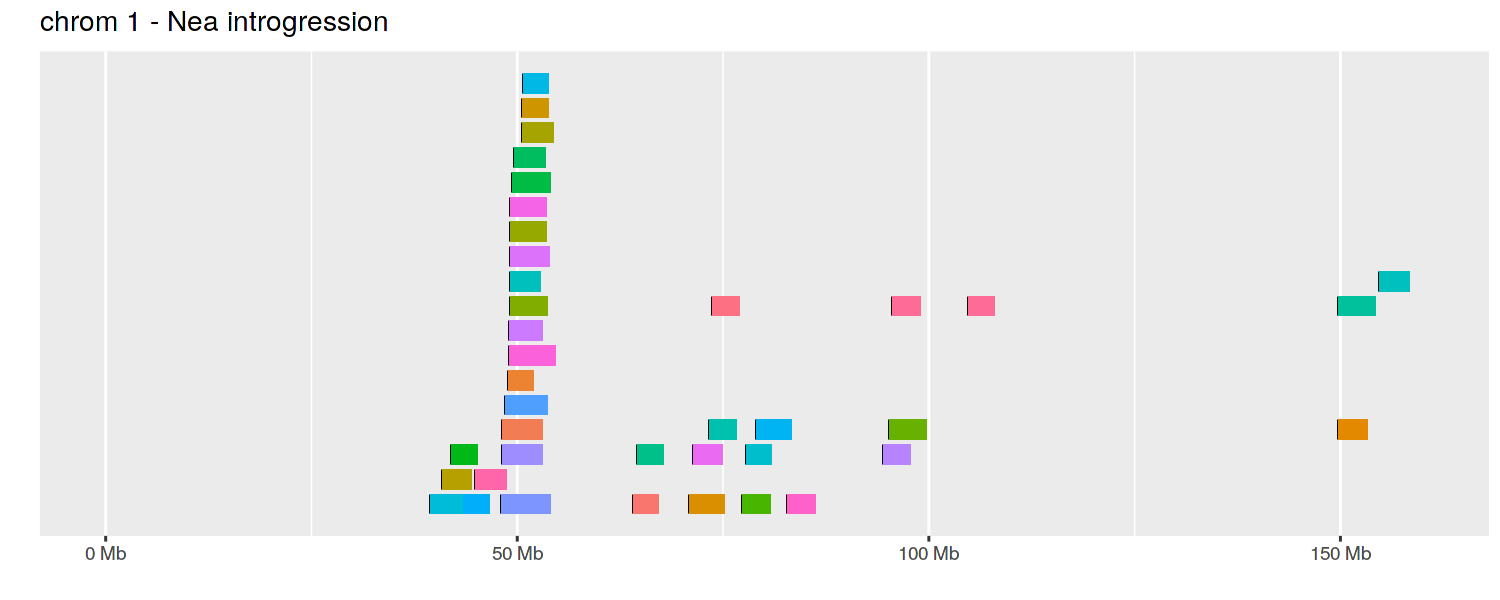

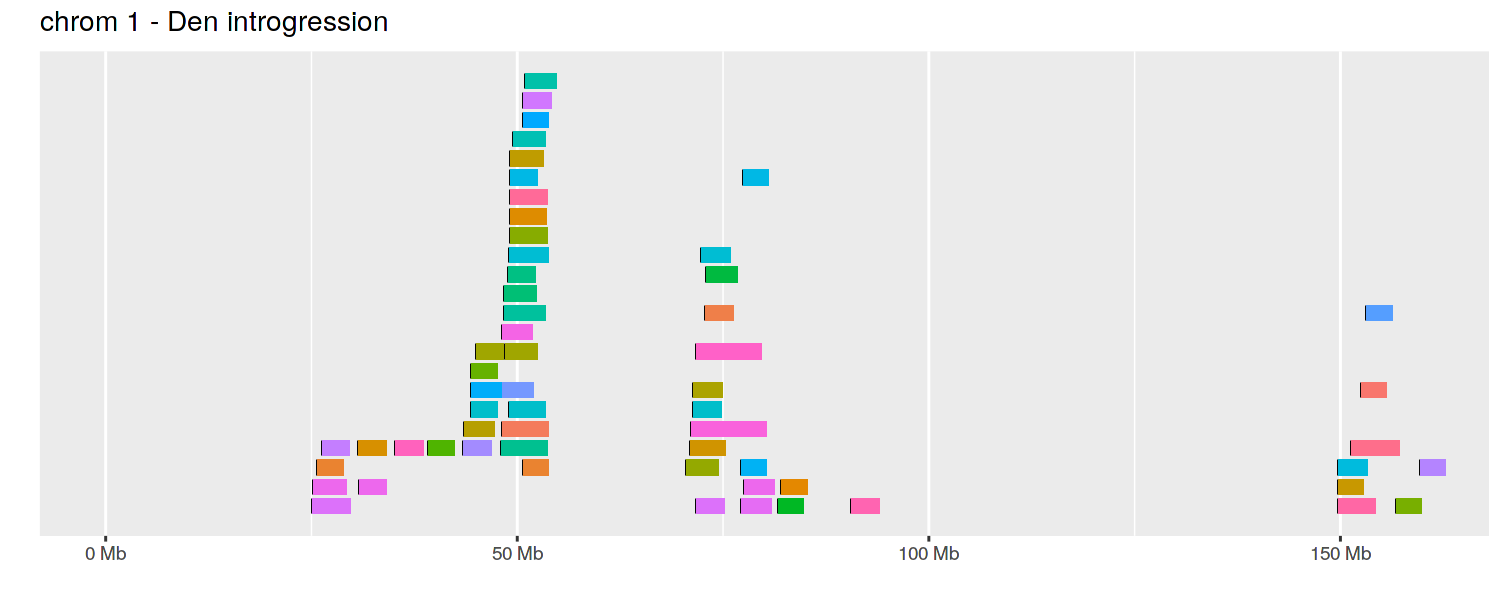

In [32]:
set_dim(10, 4)

autoplot(chr1_nea, stat = "reduce", aes(fill = factor(rep))) + xlim(IRanges(0, 160e6)) + ggtitle("chrom 1 - Nea introgression") + theme(legend.position = "none")
autoplot(chr1_den, stat = "reduce", aes(fill = factor(rep))) + xlim(IRanges(0, 160e6)) + ggtitle("chrom 1 - Den introgression") + theme(legend.position = "none")

neutral

In [16]:
scenario <- "neutral"
size_cutoff <- 3e6

In [17]:
chrom <- "chr7"

neutral_chr7_nea <- map(1:100, function(rep_i) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p2_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    largest <- deserts[width(deserts) > size_cutoff]
    
    if (! length(largest)) return(GRanges())

    largest$rep <- rep_i
    largest$pop <- "Neandertal"
    
    largest

}) %>% GRangesList

neutral_chr7_den <- map(1:100, function(rep_i) {

    deserts <- find_deserts(
        vcf_path = here("data/deserts/" %+% scenario %+% "_" %+% chrom %+% "_source_p4_exon_rep_" %+% rep_i %+% "_gen_2200.vcf.gz"),
        region = "exon",
        chrom = chrom
    )

    largest <- deserts[width(deserts) > size_cutoff]
    
    if (! length(largest)) return(GRanges())

    largest$rep <- rep_i
    largest$pop <- "Denisovan"
    
    largest

}) %>% GRangesList

Warning message in if (as.character(args$fill) == "strand") isStrand.fill <- TRUE:
"the condition has length > 1 and only the first element will be used"

Warning message in if (as.character(args$fill) == "strand") isStrand.fill <- TRUE:
"the condition has length > 1 and only the first element will be used"

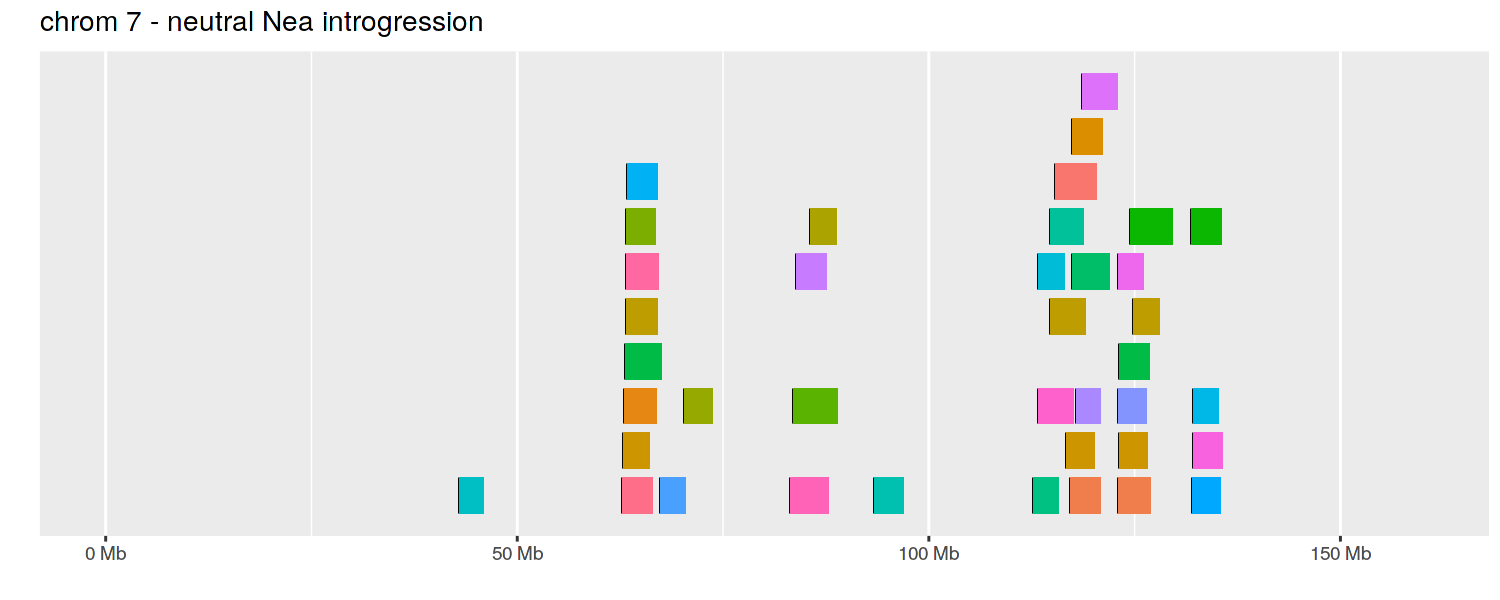

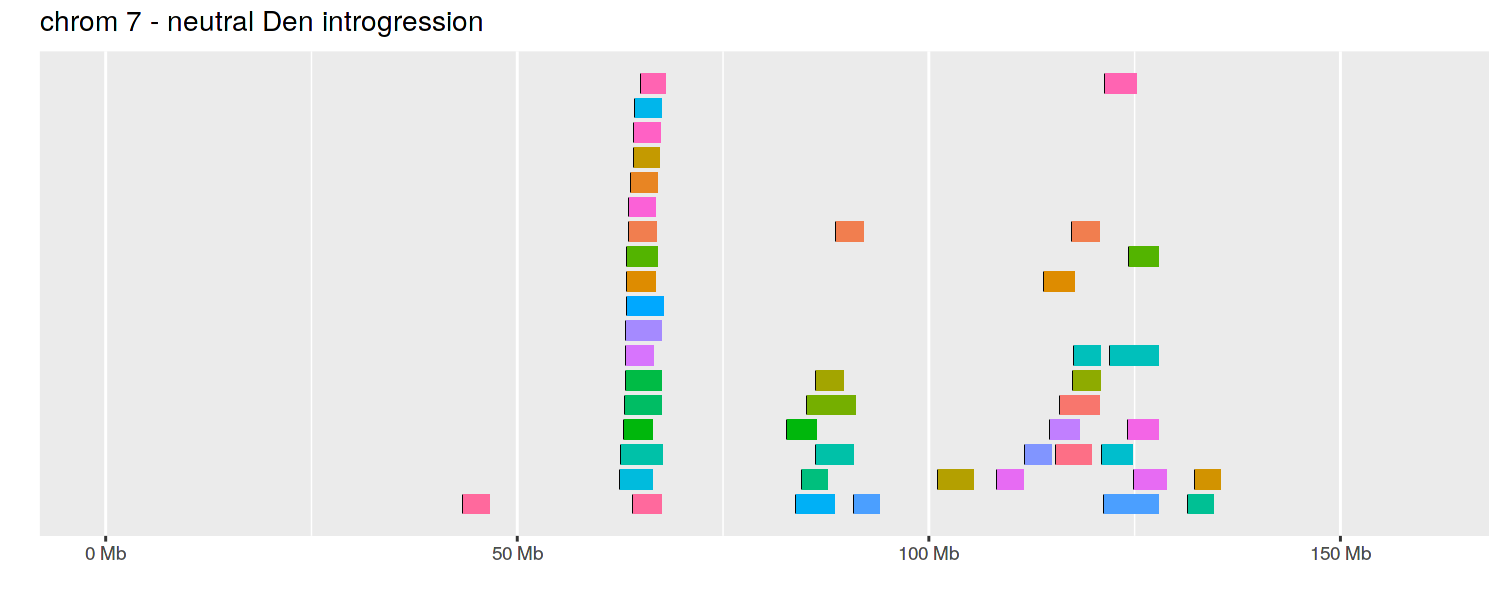

In [55]:
set_dim(10, 4)

autoplot(neutral_chr7_nea, stat = "reduce", aes(fill = factor(rep))) + xlim(IRanges(0, 160e6)) + ggtitle("chrom 7 - neutral Nea introgression") + theme(legend.position = "none")
autoplot(neutral_chr7_den, stat = "reduce", aes(fill = factor(rep))) + xlim(IRanges(0, 160e6)) + ggtitle("chrom 7 - neutral Den introgression") + theme(legend.position = "none")

In [52]:
(x <- lapply(neutral_chr7_den, function(x) x[start(x) > 62e6 & end(x) < 69e6]) %>% compact %>% GRangesList %>% unlist)

GRanges object with 18 ranges and 2 metadata columns:
       seqnames               ranges strand |       rep         pop
          <Rle>            <IRanges>  <Rle> | <integer> <character>
   [1]     chr7 [63690001, 66910001]      * |         8   Denisovan
   [2]     chr7 [63870001, 67005001]      * |        10   Denisovan
   [3]     chr7 [63375001, 66820001]      * |        12   Denisovan
   [4]     chr7 [64215001, 67310001]      * |        16   Denisovan
   [5]     chr7 [63430001, 67095001]      * |        25   Denisovan
   ...      ...                  ...    ... .       ...         ...
  [14]     chr7 [63300001, 66605001]      * |        69   Denisovan
  [15]     chr7 [63695001, 66765001]      * |        87   Denisovan
  [16]     chr7 [64215001, 67405001]      * |        94   Denisovan
  [17]     chr7 [65050001, 68055001]      * |        95   Denisovan
  [18]     chr7 [64115001, 67530001]      * |        96   Denisovan
  -------
  seqinfo: 1 sequence from an unspecified genome; no

In [54]:
assembly_gaps[seqnames(assembly_gaps) == "chr7"] %>% as.data.frame %>% arrange(start)

seqnames,start,end,width,strand,bin,ix,n,size,type,bridge
chr7,0,10000,10001,*,585,1,N,10000,telomere,no
chr7,232484,282484,50001,*,73,5,N,50000,clone,yes
chr7,50370631,50410631,40001,*,969,488,N,40000,contig,no
chr7,58054331,61054331,3000001,*,1,564,N,3000000,centromere,no
chr7,61310513,61360513,50001,*,131,569,N,50000,heterochromatin,no
chr7,61460465,61510465,50001,*,131,571,N,50000,clone,yes
chr7,61677020,61727020,50001,*,1055,573,N,50000,clone,yes
chr7,61917157,61967157,50001,*,1057,575,N,50000,heterochromatin,no
chr7,74715724,74765724,50001,*,1155,693,N,50000,clone,yes
chr7,100556043,100606043,50001,*,1352,952,N,50000,clone,yes
